In [1]:
# Plant volume notebook

# Author: Lee Hathccock

# Bring in our libraries - GDAL and OSR for reading GeoTIFFs, NumPy for array
# manipulation, matplotlib for displaying imagery

import os, sys

from osgeo import gdal
from osgeo import osr
from osgeo import ogr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# We're going to clip our image files in this case using a shapefile.

shp = ogr.Open('dsm_clip.shp')

# Get the extent, and then rearrange because Warp takes them in a different order
# than what is returned by GetExtent(). Specifically, it's xMin, yMin, xMax, yMax.
# GetExtent() returns xMin, xMax, yMin, yMax.

extent = shp.GetLayer().GetExtent()
extent_mod = [extent[0], extent[2], extent[1], extent[3]]

# Don't need to change the resolution of our summer DSM, but we are going to clip it
# using the shapefile - or more specifically the extent of the shapefile for simplicity.

#outimg = gdal.Warp("summer_dsm_clip.tif", "2023-07-07_USDA_NACA_400ft_dsm.tif", outputBounds = extent_mod,
#                    resampleAlg="nearestneighbor", options=['COMPRESS=DEFLATE'])
outimg = gdal.Warp("summer_dsm_clip.tif", "2023-07-07_USDA_NACA_400ft_dsm.tif", outputBounds = extent_mod,
                    resampleAlg=gdal.GRA_NearestNeighbour, options=['COMPRESS=DEFLATE'])
print (outimg)
outimg = None

# Let's open the generated GeoTIFF. Could have put this straight to memory instead.
img = gdal.Open("summer_dsm_clip.tif")

# Get our image's geographic information
geotransform = img.GetGeoTransform()
wkt = img.GetProjection()
proj = osr.SpatialReference(wkt)

# Definitely need our x/y cell sizes for later.
xcellsize = geotransform[1]
ycellsize = geotransform[5]

# Clip our other rasters and resample to match summer DSM.
outimg = gdal.Warp("winter_dsm_clip.tif", "2023-01-27_USDA_NACA_400ft_dsm.tif", outputBounds=extent_mod, 
                    xRes=xcellsize, yRes=ycellsize, resampleAlg=gdal.GRA_Bilinear, options=['COMPRESS=DEFLATE'])
print (outimg)
outimg = None

outimg = gdal.Warp("summer_bgren_clip.tif", "2023-07-07_USDA_NACA_400ft_BGREN_DLS_11pTarp.tif", outputBounds=extent_mod, 
                    xRes=xcellsize, yRes=ycellsize, resampleAlg=gdal.GRA_Bilinear, options=['COMPRESS=DEFLATE'])
print (outimg)
outimg = None

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000229DC8B80F0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000229DC8B82A0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000229DC8B8210> >


In [3]:
# The easiest way to change the display scale for imagery is to change the DPI.
# The larger the number, the more it will slow things down.
plt.rcParams['figure.dpi'] = 300

In [4]:
# Let's do some band math now!

# Compute NDVI from resampled BGREN mosaic.

img = gdal.Open("summer_bgren_clip.tif")
red = img.GetRasterBand(3).ReadAsArray()
nir = img.GetRasterBand(5).ReadAsArray()

ndvi = (nir - red)/(nir + red)

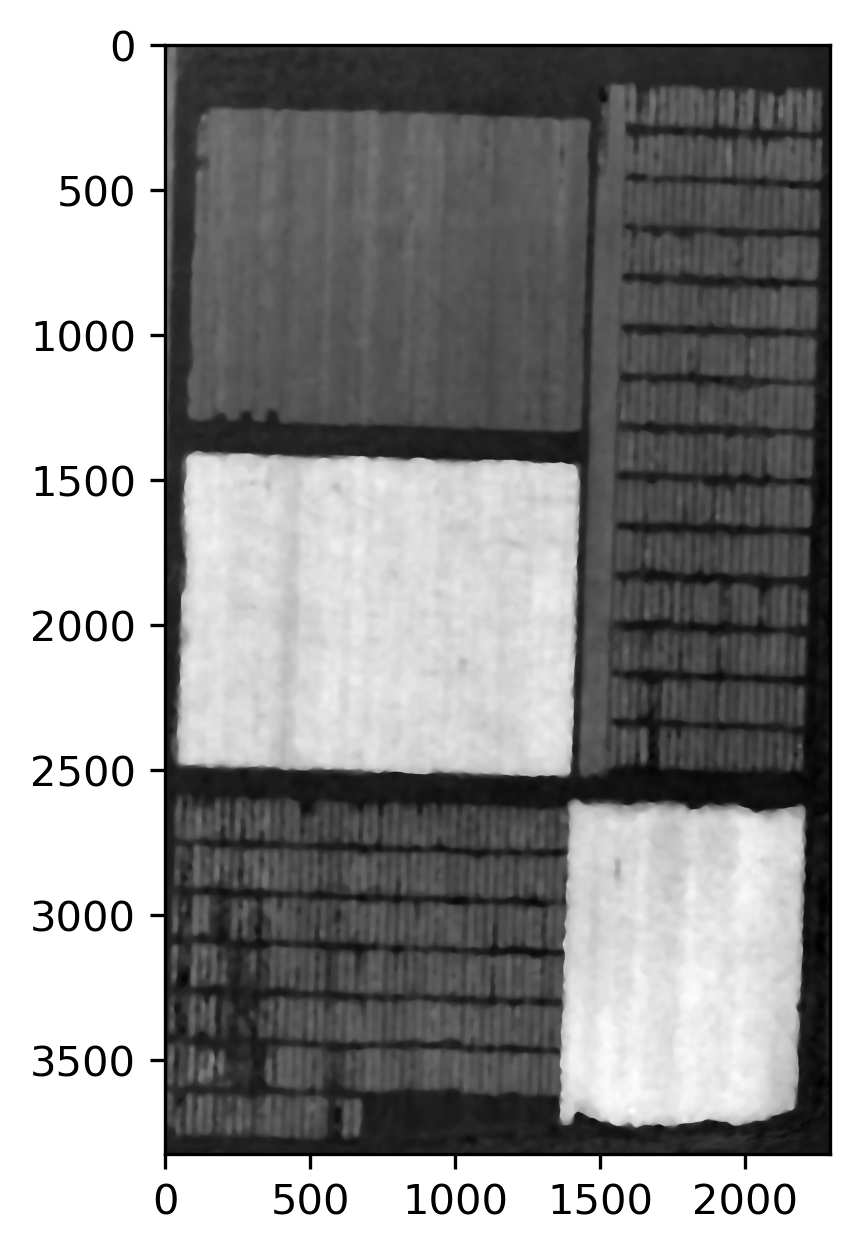

In [5]:
# Let's subtract our basemap from the summer DSM.

img = gdal.Open("summer_dsm_clip.tif")
summer_dsm = img.GetRasterBand(1).ReadAsArray()

img = gdal.Open("winter_dsm_clip.tif")
winter_dsm = img.GetRasterBand(1).ReadAsArray()

diff = summer_dsm - winter_dsm
imdiff = plt.imshow(diff, cmap='gray')


0.0
2.2414246


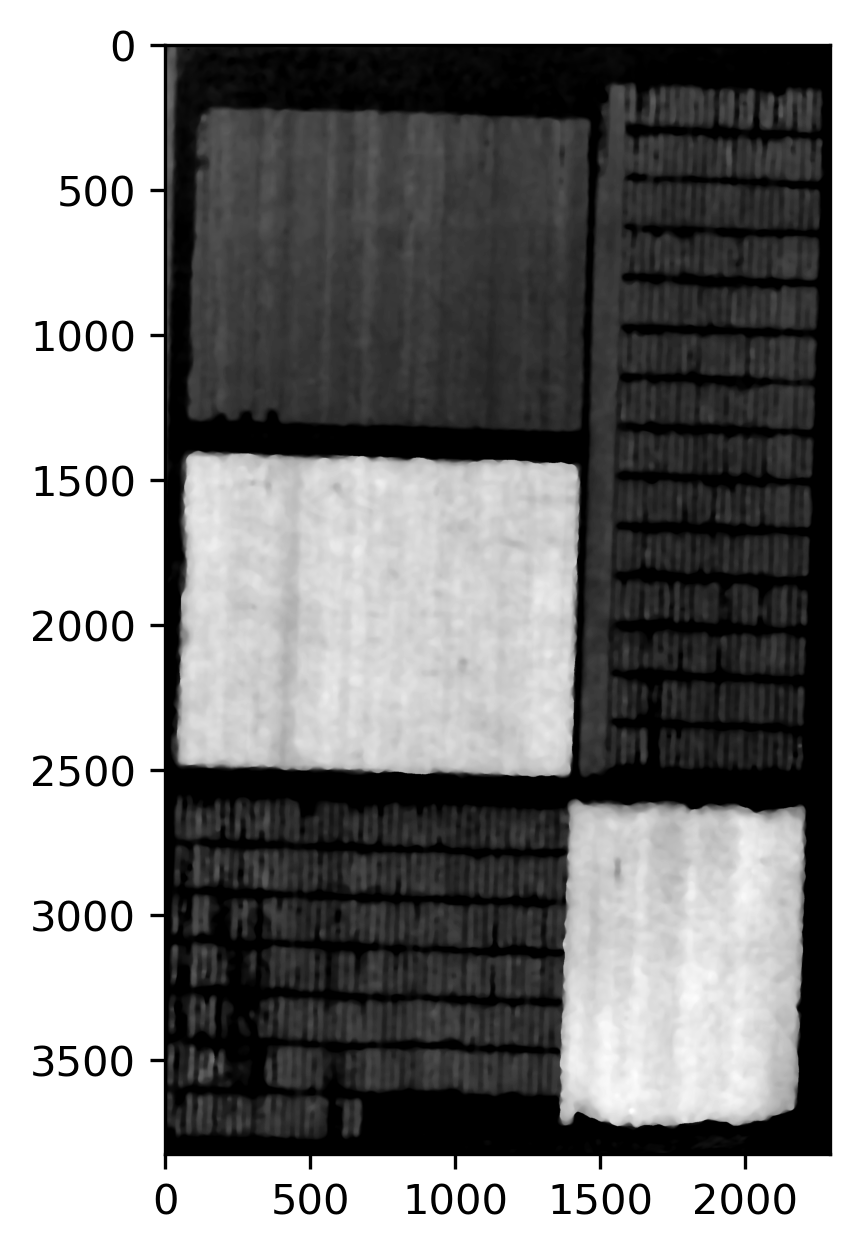

In [6]:
# Now we want to filter this for only plant material. So let's do a conditional.

# Let's also make sure we don't have negative values from vegetation that may have been present
# in winter but isn't now.

diff_filtered = np.where((ndvi < 0) | (diff < 0), 0, diff)

imdifffilt = plt.imshow(diff_filtered, cmap='gray')

print (diff_filtered.min())
print (diff_filtered.max())

0.08561325258368961 -0.08559604449937738
0.003782102614646303
0.0037821026


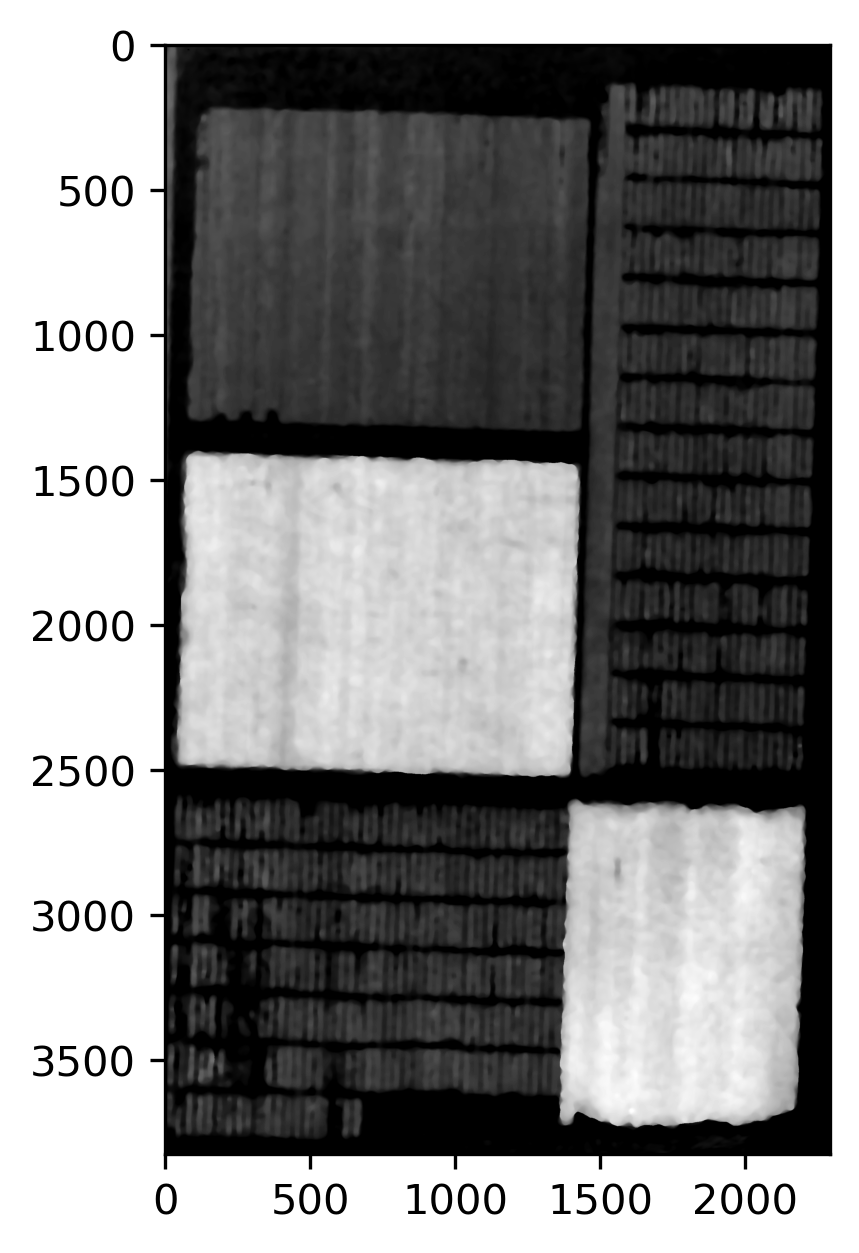

In [7]:
# Get total plant volume from DSM.

# Use X and Y resolution and height to compute volume.

print(xcellsize, ycellsize)

volume_array = diff_filtered * abs(xcellsize) * abs(ycellsize)
imvolume = plt.imshow(volume_array, cmap='gray')

print (diff_filtered[0][0] * abs(xcellsize) * abs(ycellsize))
print (volume_array[0][0])

In [8]:
# Now sum up all our individual volumes (per-pixel) to get total biomass.

total = np.sum(volume_array)
print (total)

45031.887
